In [1]:
# Import useful packages
import os
import time
import pandas as pd
# Suppressing some warnings in pandas
pd.options.mode.chained_assignment = None
import numpy as np
import glob
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, date, time, timedelta
from ta import add_all_ta_features

# Model creation packages
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error, accuracy_score, max_error
from sklearn.model_selection import train_test_split, GridSearchCV

# Importing our self-created functions
from feature_creation import *
from portfolio import *

# Importing packages needed to reload self-created functions when testing
import sys, importlib

# Dash modules
import dash
import dash_table
import dash_core_components as dcc
import dash_html_components as html
from jupyter_dash import JupyterDash
import plotly.express as px
import plotly.graph_objects as go

# For loading data from postgres
from sqlalchemy import create_engine
import psycopg2
from psycopg2 import connect

ModuleNotFoundError: No module named 'psycopg2'

In [3]:
# Use to reload a module
importlib.reload(sys.modules['portfolio'])

<module 'portfolio' from '/Users/tylerdrumheller/Documents/Grad School/SIADS697/portfolio.py'>

In [2]:
def import_technical_features():
    conn = connect(dbname = '697_temp', user = 'postgres', host = 'databasesec.cvhiyxfodl3e.us-east-2.rds.amazonaws.com', password = 'poRter!5067')
    cur = conn.cursor()
    query = "SELECT * FROM technical_features_daily"
    data = pd.read_sql_query(query,conn)
    data = data.sort_values(['ticker', 'Date'])
    data['Date'] = pd.to_datetime(data['Date'])
    data = data.set_index('Date')
    return data
feature_df = import_technical_features()

# Or just load if no need to re-create features
# feature_df = pd.read_csv('assets/models/tyler_rf_daily_update/ta_feature_df.csv',index_col=0)

# Ensure index is datetime
# feature_df.index = pd.to_datetime(feature_df.index)

feature_df.head()

Adj Close      Close  Close_adj  Dividends       High   High_adj  \
Date                                                                           
2017-01-03  44.773853  44.773853  46.490002        0.0  45.024254  46.750000   
2017-01-04  45.361336  45.361336  47.099998        0.0  45.631002  47.380001   
2017-01-05  44.822021  44.822021  46.540001        0.0  45.332456  47.070000   
2017-01-06  46.218483  46.218483  47.990002        0.0  46.295528  48.070000   
2017-01-09  46.362946  46.362946  48.139999        0.0  46.767443  48.560001   

                  Low    Low_adj       Open   Open_adj  ...  momentum_wr  \
Date                                                    ...                
2017-01-03  44.051539  45.740002  44.234524  45.930000  ...   -18.934957   
2017-01-04  45.091673  46.820000  45.197613  46.930000  ...   -13.017484   
2017-01-05  44.648666  46.360001  45.313194  47.049999  ...   -39.051549   
2017-01-06  44.841270  46.560001  44.908686  46.630001  ...    -2.815870   
2017-01-09  46.141436  47.910000  46.237743  48.009998  ...   -12.608987   

            momentum_ao momentum_kama momentum_roc  momentum_ppo  \
Date                                                               
2017-01-03     0.652427     43.960978     1.050305    -14.557534   
2017-01-04     0.759583     44.117789     1.452683    -11.329006   
2017-01-05     0.847551     44.131201     1.665804    -10.367377   
2017-01-06     1.128783     44.333750     5.940935     -2.581875   
2017-01-09     1.565163     44.559215     4.478225      1.637793   

            momentum_ppo_signal  momentum_ppo_hist  others_dr  others_dlr  \
Date                                                                        
2017-01-03           -14.511079          -0.046455   2.041252    2.020697   
2017-01-04           -13.874665           2.545658   1.312111    1.303577   
2017-01-05           -13.173207           2.805830  -1.188929   -1.196054   
2017-01-06           -11.054941           8.473066   3.115570    3.068021   
2017-01-09            -8.516394          10.154187   0.312565    0.312077   

            others_cr  
Date                   
2017-01-03  64.998080  
2017-01-04  67.163037  
2017-01-05  65.175587  
2017-01-06  70.321748  
2017-01-09  70.854113  

[5 rows x 103 columns]

In [2]:
# Used for Tyler's macbook air due to compatibility issues
# Or just load if no need to re-create features
feature_df = pd.read_csv('assets/models/tyler_rf_daily_update/ta_feature_df.csv',index_col=0)

# Ensure index is datetime
feature_df.index = pd.to_datetime(feature_df.index)

feature_df.head()

Adj Close     Close  Close_adj  Dividends      High  High_adj  \
Date                                                                        
1990-02-16   0.056967  0.056967   0.077257        0.0  0.058887  0.079861   
1990-02-20   0.058887  0.058887   0.079861        0.0  0.058887  0.079861   
1990-02-21   0.057607  0.057607   0.078125        0.0  0.058247  0.078993   
1990-02-22   0.058247  0.058247   0.078993        0.0  0.060167  0.081597   
1990-02-23   0.057927  0.057927   0.078559        0.0  0.058887  0.079861   

                 Low   Low_adj  Open  Open_adj  ...  momentum_wr  momentum_ao  \
Date                                            ...                             
1990-02-16  0.054407  0.073785   0.0       0.0  ...   -42.857143          0.0   
1990-02-20  0.055047  0.074653   0.0       0.0  ...    -0.000804          0.0   
1990-02-21  0.055687  0.075521   0.0       0.0  ...   -28.571863          0.0   
1990-02-22  0.058247  0.078993   0.0       0.0  ...   -33.333463          0.0   
1990-02-23  0.057607  0.078125   0.0       0.0  ...   -38.889100          0.0   

           momentum_kama momentum_roc  momentum_ppo  momentum_ppo_signal  \
Date                                                                       
1990-02-16      0.056967          0.0      0.000000             0.000000   
1990-02-20      0.057802          0.0     -7.132343            -1.426469   
1990-02-21      0.057718          0.0    -14.352665            -4.011708   
1990-02-22      0.057944          0.0    -21.164525            -7.442271   
1990-02-23      0.057937          0.0    -27.325018           -11.418821   

            momentum_ppo_hist  others_dr  others_dlr  others_cr  
Date                                                             
1990-02-16           0.000000 -99.670356    0.000000   0.000000  
1990-02-20          -5.705874   3.370505    3.314949   3.370505  
1990-02-21         -10.340957  -2.173750   -2.197724   1.123489  
1990-02-22         -13.722254   1.111033    1.104906   2.247004  
1990-02-23         -15.906197  -0.549422   -0.550937   1.685236  

[5 rows x 103 columns]

In [3]:
# Simple visualization of a ticker price over time to ensure data looks accurate
fig = go.Figure()

ticker = 'AAPL'
df = feature_df[(feature_df['ticker']==ticker)&(feature_df.index>='2018-01-01')]

fig.add_trace(go.Scatter(x=df.index,
                         y=df['Close'],
                        line={"color": "#228B22"},
                        mode="lines",
                        name='Closing Price'))

fig.add_trace(go.Scatter(x=df.index,
                         y=df['trend_sma_fast'],
                        line={"color": "red","dash":"dash","width":1},
                        mode="lines",
                        name='Closing Price'))

fig.add_trace(go.Scatter(x=df.index,
                         y=df['trend_sma_slow'],
                        line={"color": "black","dash":"dash","width":1},
                        mode="lines",
                        name='Closing Price'))

fig.update_layout(title_text=f'{ticker} Closing Price',title_x=0.5,
                         template="ggplot2",font=dict(size=10,color='black'),xaxis_showgrid=False,
                         paper_bgcolor='rgba(0,0,0,0)',
                         yaxis_title="Closing Price",margin={"r": 20, "t": 35, "l": 20, "b": 10},
                         showlegend=False)

fig.show()

## Part 1: Feature Selection
#### In this section, we train a lightly configured Random Forest Regressor to get feature importance of all features. Using this set of features, we order based on importance and only select features over a certain threshold of importance

In [4]:
# Creating sample df for AAPL only, as we train models for all tickers eventually
sample_df = feature_df[(feature_df['ticker']=='AAPL')&(feature_df.index>='2018-01-01')&\
                       (feature_df.index<='2020-12-31')]

# Creating target variables to look at performance in forecasting at different time horizons
sample_df['target_7'] = sample_df['Close_adj'].shift(-7)
sample_df['target_30'] = sample_df['Close_adj'].shift(-30)
sample_df['target_60'] = sample_df['Close_adj'].shift(-60)
sample_df['target_120'] = sample_df['Close_adj'].shift(-120)

In [5]:
# Test Train split
split_perc = .8
train_df = sample_df.iloc[:int(len(sample_df)*split_perc)]
test_df = sample_df.iloc[int(len(sample_df)*split_perc):]

# Ensuring the test/train split worked correctly
fig = go.Figure()

fig.add_trace(go.Scatter(x=train_df.index,
                         y=train_df['Close_adj'],
                        line={"color": "#228B22"},
                        mode="lines",
                        name='Train'))

fig.add_trace(go.Scatter(x=test_df.index,
                         y=test_df['Close_adj'],
                        line={"color": "red"},
                        mode="lines",
                        name='Test'))

In [6]:
# Get actual feature columns from train_df
features = list(train_df.columns)[15:len(train_df.columns)-4]
features.extend(['Adj Close','High_adj','Low_adj','Open_adj'])

In [7]:
# Training our initial RF Reg model
X = train_df[features]
y = train_df['target_7']

# If scaling is needed
# scaler = StandardScaler()
# X_Scaled = scaler.fit_transform(X)

# Using a Random Forest Regressor to test time horizon predictions
regr = RandomForestRegressor(max_depth=5, random_state=0)

regr.fit(X, y)

RandomForestRegressor(max_depth=5, random_state=0)

In [8]:
# Plotting feature importance. Vast majority of features seem to be of no use to the model, so will drop
fig = go.Figure()

feats = [x for _, x in sorted(zip(regr.feature_importances_,features),reverse=True)]
importance = sorted(regr.feature_importances_,reverse=True)

fig.add_trace(go.Bar(x=feats, y=importance,name="Feature Importance"))

fig.add_trace(go.Scatter(x=feats,
                         y=np.cumsum(sorted(regr.feature_importances_,reverse=True)),
                         line={"color":"black"},
                         mode="lines",
                         name="Cumulative Importance"
                        ))

fig.show()

In [9]:
# Getting only features that are important up to a threshold
thresh = .9
thresh_len = len([x for x in np.cumsum(sorted(regr.feature_importances_,reverse=True)) if x <= thresh])

# Using this loop to ensure features we keep are adding substantial value
[x for x in np.cumsum(sorted(regr.feature_importances_,reverse=True)) if x <= thresh]

[0.08453112639998188,
 0.15512932921360306,
 0.22514085670600542,
 0.2950794899515831,
 0.3596083403431524,
 0.4144087357694752,
 0.4690750092365454,
 0.5234694695830443,
 0.575300409108591,
 0.6220675129044686,
 0.6606675225231645,
 0.6947222448118376,
 0.7270720821658124,
 0.7585888658158788,
 0.789707820622331,
 0.820748293735024,
 0.8500282130901614,
 0.8733337163620454,
 0.8963818980915682]

## Part 2: Exploring Target Variables
#### We are going to explore model prediction capabilities by training 4 models tasked with predicting future price over some time horizon (7, 30, 60, 120 days), which will tell us if we should be buying or selling to take advantage of price changes

In [10]:
# Including all features under importance threshold
updated_feats = feats[:thresh_len+1]

# Re-training model with smaller subset of features
regr = RandomForestRegressor(max_depth=10, n_estimators= 100, random_state=0)

X = train_df[updated_feats]
y = train_df['target_7']

# If scaling is needed
# X_Scaled = scaler.fit_transform(X)

regr.fit(X, y)

feat_importance_7 = regr.feature_importances_

# R^2 is very high. This model is most likely highly overfit
print(f'R^2 for Model: {np.round(regr.score(X,y),4)}')

R^2 for Model: 0.9972


In [29]:
# Creating our train data points from predicting our target
train_predictions = regr.predict(X)

X_test = test_df[updated_feats]

# If scaling is needed
# X_test_scaled = scaler.fit_transform(test_df[updated_feats])

# Creating our test data points from predicting our target
test_predictions = regr.predict(X_test)

fig = go.Figure()

fig.add_trace(go.Scatter(x=train_df.index,
                         y=train_df['Close_adj'],
                        line={"color": "#228B22"},
                        mode="lines",
                        name='Train'))

fig.add_trace(go.Scatter(x=train_df.index+timedelta(days=7),
                         y=train_predictions,
                        line={"color": "gray","dash":"dash"},
                        mode="lines",
                        name='Train Predictions'))

fig.add_trace(go.Scatter(x=test_df.index,
                         y=test_df['Close_adj'],
                        line={"color": "#228B22","dash":"dash"},
                        mode="lines",
                        name='Test Actuals'))

fig.add_trace(go.Scatter(x=test_df.index+timedelta(days=7),
                         y=test_predictions,
                        line={"color": "red"},
                        mode="lines",
                        name='Test Predictions (7 Day)'))

#### Observations:
1. Looking at prediction performance. So far, our model does a horrible job at predicting the future
2. Will look into some thresholding on price projections/ROI to making buying/selling decisions
3. Why does scaling not work?

#### Adding additional models with longer targets

In [30]:
# Training a model on 30_Day
regr = RandomForestRegressor(max_depth=5, random_state=0)

X = train_df[updated_feats]
y = train_df['target_30']

regr.fit(X, y)

feat_importance_30 = regr.feature_importances_

print(f'R^2 for Model: {np.round(regr.score(X,y),4)}')

test_predictions = regr.predict(test_df[updated_feats])

fig.add_trace(go.Scatter(x=test_df.index+timedelta(days=30),
                         y=test_predictions,
                        line={"color": "red","dash":"dash"},
                        mode="lines",
                        name='Test Predictions (30 Day)'))

R^2 for Model: 0.9614


In [31]:
# Training a model on 60_Day
regr = RandomForestRegressor(max_depth=5, random_state=0)

X = train_df[updated_feats]
y = train_df['target_60']

regr.fit(X, y)

feat_importance_60 = regr.feature_importances_

# R^2 is very high. This model is most likely highly overfit
print(f'R^2 for Model: {np.round(regr.score(X,y),4)}')

test_predictions = regr.predict(test_df[updated_feats])

fig.add_trace(go.Scatter(x=test_df.index+timedelta(days=60),
                         y=test_predictions,
                        line={"color": "blue"},
                        mode="lines",
                        name='Test Predictions (60 Day)'))

R^2 for Model: 0.9401


In [32]:
# Training a model on 120_Day
regr = RandomForestRegressor(max_depth=5, random_state=0)

X = train_df[updated_feats]
y = train_df['target_120']

regr.fit(X, y)

feat_importance_120 = regr.feature_importances_

# R^2 is very high. This model is most likely highly overfit
print(f'R^2 for Model: {np.round(regr.score(X,y),4)}')

test_predictions = regr.predict(test_df[updated_feats])

fig.add_trace(go.Scatter(x=test_df.index+timedelta(days=120),
                         y=test_predictions,
                        line={"color": "blue","dash":"dash"},
                        mode="lines",
                        name='Test Predictions (120 Day)'))

R^2 for Model: 0.9676


<AxesSubplot:>

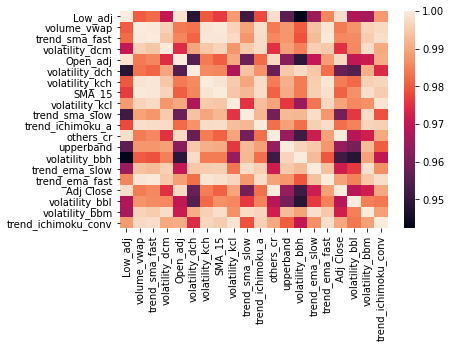

In [33]:
import seaborn as sns
# Looking at correlation between features, we have quite high correlation between all
corr = train_df[updated_feats].corr()

sns.heatmap(corr)

In [17]:
[x for _, x in sorted(zip(feat_importance_7,updated_feats),reverse=True)]

['Open_adj',
 'Low_adj',
 'volume_vwap',
 'volatility_kch',
 'volatility_bbh',
 'volatility_dcm',
 'trend_ema_fast',
 'trend_sma_fast',
 'volatility_kcl',
 'Adj Close',
 'volatility_dch',
 'trend_ichimoku_conv',
 'trend_sma_slow',
 'momentum_kama',
 'others_cr',
 'trend_ema_slow',
 'volatility_bbm',
 'upperband',
 'volatility_bbl',
 'trend_kst',
 'High_adj',
 'trend_ichimoku_a',
 'SMA_15',
 'volatility_dcl',
 'trend_ichimoku_base']

In [34]:
from plotly.subplots import make_subplots
fig2 = make_subplots(rows=2, cols=2)

# Adding features by importance for 7 day model
feats_7 = [x for _, x in sorted(zip(feat_importance_7,updated_feats),reverse=True)]
importance_7 = sorted(feat_importance_7,reverse=True)


fig2.add_trace(
    go.Bar(x=feats_7, y=importance_7,name='7 Day'),
    row=1, col=1
)

# Adding features by importance for 30 day model
feats_30 = [x for _, x in sorted(zip(feat_importance_30,updated_feats),reverse=True)]
importance_30 = sorted(feat_importance_30,reverse=True)
fig2.add_trace(
    go.Bar(x=feats_30, y=importance_30,name='30 Day'),
    row=1, col=2
)

# Adding features by importance for 60 day model
feats_60 = [x for _, x in sorted(zip(feat_importance_60,updated_feats),reverse=True)]
importance_60 = sorted(feat_importance_60,reverse=True)
fig2.add_trace(
    go.Bar(x=feats_60, y=importance_60,name='60 Day'),
    row=2, col=1
)

# Adding features by importance for 60 day model
feats_120 = [x for _, x in sorted(zip(feat_importance_120,updated_feats),reverse=True)]
importance_120 = sorted(feat_importance_120,reverse=True)
fig2.add_trace(
    go.Bar(x=feats_120, y=importance_120,name='120 Day'),
    row=2, col=2
)

fig2.update_layout(height=1200, width=1000, title_text="Feature Importance by Target")
fig2.show()

#### Observations:
1. Every model does a fairly good job of predicting the first data point forecasted in the future, but performance drops off significantly from there
2. Also, our train predictions all have R^2 around or greater than 97%, which is common for Random Forest models, that can have a tendency to overfit
3. Interesting enough, all models have variation in what features they think are important, and the 7 day model has a greater didstribution of technical features with similar importance
4. What objective function should I actually be using?
5. Should I weight predictions and decisions based on model backtesting performance?

## Part 2b: Perform GridSearch to Find Best Model Configuration

In [35]:
def pipeline(X, y):
    """Trains, tests, and evaluates classification model using GridSearch"""
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    param_grid = {'n_estimators': [100, 200, 500],
              'max_depth': [5, 10, 15],
              "max_features": ['auto', 'sqrt', 'log2'],
              "criterion": ['mse', 'mae']}
    scorers = {
        'mse': make_scorer(mean_squared_error),
        'max_error' : make_scorer(max_error)
    }

    etc = RandomForestRegressor(random_state=42,n_jobs=-1)
    clf = GridSearchCV(etc, param_grid=param_grid, cv=3, refit='mse',
                       return_train_score=True, scoring=scorers)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    t = clf.best_params_
    print(t)

    results = pd.DataFrame(clf.cv_results_)
#     results.to_csv('mod_1_gsresults.csv')
    return t, X_train, X_test, y_train, y_test, clf, results

In [36]:
t, X_train, X_test, y_train, y_test, clf, cv_results = pipeline(train_df[updated_feats], train_df['target_30'])

{'criterion': 'mae', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 100}


In [37]:
t

{'criterion': 'mae',
 'max_depth': 5,
 'max_features': 'sqrt',
 'n_estimators': 100}

## Part 3: Using past knowledge to re-train our model
#### Given we see every first point we predict is much more aligned to actual test data, we will explore an approach that will allow us to re-train the model every day once we have additional info

In [39]:
new_train_df = train_df
test_preds = []
test_dates = []

# Need to remove last 7 observations due to missing price for 7 days in the future
for i in range(len(test_df)-7):

    # Creating next prediction point
    test_point = test_df[updated_feats].iloc[[i]]

    X = new_train_df[updated_feats]
    y = new_train_df['target_7']

    regr = RandomForestRegressor(max_depth=5,n_estimators=100,criterion='mae',max_features='sqrt',random_state=0)

    regr.fit(X, y)

    test_prediction = regr.predict(test_point)[0]
    test_date = test_point.index.values[0]

    test_preds.append(test_prediction)
    test_dates.append(test_date)
    
    # Adding next observation to our training data to simulate re-training a model daily
    new_train_df = pd.concat([new_train_df,test_df.iloc[[i]]])
    
# Adding the final predictions for obersavtions without the target variable
for i in range(len(test_df)-7,len(test_df)):
    
    test_point = test_df[updated_feats].iloc[[i]]
    
    test_prediction = regr.predict(test_point)[0]
    test_date = test_point.index.values[0]
    
    test_preds.append(test_prediction)
    test_dates.append(test_date)

In [40]:
# Creating DF with new preds to allow for easy plotting
new_test_df = pd.DataFrame(data=test_preds,index=test_dates,columns=['7_Day'])

In [41]:
# Plotting our new re-fitted predictions with test data
# Fit is much more appropriate...why??
fig = go.Figure()

fig.add_trace(go.Scatter(x=test_df.index,
                         y=test_df['Close'],
                        line={"color": "#228B22","dash":"dash"},
                        mode="lines",
                        name='Test Actuals'))

fig.add_trace(go.Scatter(x=new_test_df.index+timedelta(days=7),
                         y=new_test_df['7_Day'],
                        line={"color": "red"},
                        mode="lines",
                        name='Test Predictions (7 Day)'))

In [298]:
# # warm start method
# new_train_df = train_df
# test_preds = []
# test_dates = []

# # Need to remove last 7 observations due to missing price for 7 days in the future
# for i in range(len(test_df)-7):

#     # Creating next prediction point
#     test_point = test_df[updated_feats].iloc[[i]]
    
#     # Initializing model
#     if i == 0:

#         X = new_train_df[updated_feats]
#         y = new_train_df['target_7']

#         regr = RandomForestRegressor(max_depth=5,n_estimators=100,criterion='mae',max_features='sqrt',\
#                                      warm_start=True,random_state=0)

#         regr.fit(X, y)

#         test_prediction = regr.predict(test_point)[0]
#         test_date = test_point.index.values[0]

#         test_preds.append(test_prediction)
#         test_dates.append(test_date)
        
#     if i != 0:
    
#         # Adding next observation to our training data to simulate re-training a model daily
#         X = test_df.iloc[[i]][updated_feats]
#         y = test_df.iloc[[i]]['target_7']

#         regr.fit(X, y)
        
#         test_prediction = regr.predict(test_point)[0]
#         test_date = test_point.index.values[0]

#         test_preds.append(test_prediction)
#         test_dates.append(test_date)
    
# # Adding the final predictions for observations without the target variable
# for i in range(len(test_df)-7,len(test_df)):
    
#     test_point = test_df[updated_feats].iloc[[i]]
    
#     test_prediction = regr.predict(test_point)[0]
#     test_date = test_point.index.values[0]
    
#     test_preds.append(test_prediction)
#     test_dates.append(test_date)

#### Observations:
1. As expected, re-training our model daily provides much better accuracy for making predictions into the future, as we are able to incorporate new information for each model build
2. I believe this is true given we are able to minimize the effects of the "random walk" theory commonly attributed to stock market price movements. We are able to better minimize the effects of exogenous or econmomic factors that actually lead to more concrete changes in stock prices

## Part 4: Picking a subset of tickers and creating models for each
#### In this section, we will make assumptions about tickers and their performance (based on research/tribal knowledge) and build models for each to allow us to start to create a diversified portfolio

In [4]:
# Could pick tickers with lowest industry P/E ratios, but for now only picking popular stocks
# getting all sectors to get largest tickers by volumes
sectors = list(feature_df.sector.unique())

# Creating function to get largest tickers for a sector
def largest_tickers_by_vol(sector):
    return list(feature_df[feature_df['sector']==sector].groupby('ticker').mean('Volume')['Volume'].nlargest(5).index.values)

tickers = []

for sector in sectors:
    tickers.extend(largest_tickers_by_vol(sector))

tickers[:10]

['AAPL', 'MSFT', 'CSCO', 'INTC', 'ORCL', 'GE', 'CSX', 'AAL', 'DAL', 'UAL']

In [5]:
# Setting these manually so I dont have to re-run the rest of the notebook
updated_feats = ['Low_adj', 'volume_vwap', 'trend_sma_fast', 'volatility_dcm', 'Open_adj', 'volatility_dch',
 'volatility_kch', 'SMA_15', 'volatility_kcl', 'trend_sma_slow', 'trend_ichimoku_a', 'others_cr',
 'upperband', 'volatility_bbh', 'trend_ema_slow', 'trend_ema_fast', 'Adj Close', 'volatility_bbl',
 'volatility_bbm', 'trend_ichimoku_conv', 'trend_ichimoku_base', 'High_adj', 'momentum_kama',
 'volatility_dcl', 'trend_kst']

In [6]:
# Define function to fit a model that predicts price performance over some time horizon
def fit_model(ticker,train_start_dt,train_end_dt,target=7):

    # Creating sample df for ticker only
    sample_df = feature_df[(feature_df['ticker']==ticker)&(feature_df.index>=train_start_dt)&\
                           (feature_df.index<=train_end_dt)].fillna(method="ffill")

    # Backfilling if forward filling didn't work
    sample_df = feature_df[(feature_df['ticker']==ticker)&(feature_df.index>=train_start_dt)&\
                           (feature_df.index<=train_end_dt)].fillna(method="bfill")

    # Creating target variable to predict prices X days in future
    sample_df[f'target_{target}'] = sample_df['Close_adj'].shift(-1*target)

    # Dropping 7 most recent dates given there is no prediction
    train_df = sample_df.dropna()

    # Fitting my model on inital train_df
    X = train_df[updated_feats]
    y = train_df[f'target_{target}']

    regr = RandomForestRegressor(max_depth=5,n_estimators=100,criterion='mae',max_features='sqrt',random_state=0)
    regr.fit(X, y)

    # Getting trading days calendar to add prediction to N trading days in future
    nyse = mcal.get_calendar('NYSE')
    train_end_dt_for_cal = datetime.strptime(train_end_dt,"%Y-%m-%d")
    valid_days = list(nyse.valid_days(start_date=train_end_dt_for_cal, end_date=train_end_dt_for_cal+timedelta(days=target+120)))

    # Getting X trading days in future
    test_date = valid_days[target].strftime('%Y-%m-%d')
    test_prediction = regr.predict(sample_df[updated_feats].iloc[[-1]])[0]

    return test_date, test_prediction, regr

In [7]:
# Testing out our function with one model creation for AAPL
fit_model('AAL','2016-01-01','2020-05-28')

('2020-06-08',
 10.321999950408935,
 RandomForestRegressor(criterion='mae', max_depth=5, max_features='sqrt',
                       random_state=0))

In [57]:
run_df = pd.DataFrame(columns=['target','rebal_interval','ticker_preds','hist_open_positions','model','train_start_dt'])

In [51]:
# Putting everything above together
# This will assess prices and predictions every 7 days and change positions accordingly

# Setting training dates. Will test on all data after
train_start_dt = '2017-01-01'

# Filtering to new_df just with dates we care about
new_df = feature_df[feature_df.index >=train_start_dt]

# Creating train_df and test_df
split_perc = .8
# Getting index values needed to split df
train_int = int(len(new_df.index.unique())*split_perc)

# Splitting new_df into train_df and test_df
train_df = new_df[new_df.index.isin(new_df.index.unique()[:train_int])]
test_df = new_df[new_df.index.isin(new_df.index.unique()[train_int:])]

train_end_dt = pd.to_datetime(new_df[new_df.index.isin(new_df.index.unique()[:train_int])]\
                              .index.max()).date().strftime('%Y-%m-%d')

# Initializing portfolio
# start_dt = test_df.index.min().strftime('%Y-%m-%d')
port = portfolio(start_date=train_end_dt,value=10000)
hist_open_positions = {}

ticker_preds = pd.DataFrame(columns=['ticker','pred_date','pred_price','curr_price','earn_ratio'])

iteration = 0

# Setting configuration variables
target = 7
rebal_interval = 7 # Rebalance (buy/sell) every 7 days

for i in range(0,len(test_df.index.unique()),rebal_interval):

    # Changing train end date for every iteration
    next_train_end_dt = (pd.to_datetime(train_end_dt)+timedelta(i)).strftime('%Y-%m-%d')

    # Re-fit every ticker model and predict price in the future
    for ticker in tickers:

        pred_date, pred_price, model = fit_model(ticker,train_start_dt,next_train_end_dt,target=target)

        # Current price doesn't match actual price, because the function averages multiple prices
        curr_price = port.get_price(date=pred_date,ticker=ticker)
        earn_ratio = pred_price / curr_price - 1

        ticker_preds = ticker_preds.append({'ticker':ticker,'pred_date':pred_date,'pred_price':pred_price,\
                                        'curr_price':curr_price,'earn_ratio':earn_ratio},ignore_index=True)

    # Creating dictinary of stocks and positions to sell
    try:
        sell_dict = create_sell_dict(ticker_preds[ticker_preds['pred_date']==pred_date],port.open_positions_dict,\
                                                         sell_threshold = -0.05)
        print(f'Current Selected Sells: {sell_dict} for {next_train_end_dt}')

        # Selling positions of stocks predicted to decline on day of training (EOD)
        port.sell(sell_dict,next_train_end_dt)

    # If no sells exist, then pass
    except:
        pass

    # Creating dictinary of stocks and positions to buy
    try:
        buy_dict = create_buy_dict(ticker_preds[ticker_preds['pred_date']==pred_date],port.current_cash,\
                                                                                   buy_threshold=0.05)
        print(f'Current Selected Buys: {buy_dict} for {next_train_end_dt}')

        # Buying positions of stocks predicted to increase on day of training (EOD)
        port.buy(buy_dict,next_train_end_dt)

    # If no buying exists, then pass
    except:
        pass

    iteration+=1
    hist_open_positions[next_train_end_dt] = port.open_positions_dict.copy()
#     print(port.open_positions_dict)
#     print(next_train_end_dt)

    print(f'Current Progress: {iteration} out of {int(len(test_df.index.unique())/rebal_interval)+1}')

    # Adding a break point for testing
    if iteration >= 5:
        break

run_df = run_df.append(pd.DataFrame.from_dict({'target':target,'rebal_interval':rebal_interval,'ticker_preds':ticker_preds,\
                             'hist_open_positions':hist_open_positions,'model':model,'train_start_dt':train_start_dt},orient='index').transpose())

KeyboardInterrupt: 

In [72]:
run_df

target rebal_interval                                       ticker_preds  \
0      7              7      ticker   pred_date  pred_price  curr_price...   

                                 hist_open_positions  \
0  {'2020-05-28': {'NEM': 82, 'PFE': 99, 'AMGN': ...   

                                               model  
0  (DecisionTreeRegressor(max_depth=5, max_featur...

In [ ]:
# Can only by 8 of AMGN given not enough funds

In [205]:
# curr_val_dict = {}

In [195]:
# date = '2020-06-30'
# curr_val = 0

# for key, value in hist_open_positions.items():
#     curr_val += port.tracking_df[port.tracking_df.index==date][key].values[0]*value

#     curr_val_dict[date] = curr_val

In [196]:
# curr_val_dict

In [197]:
# sum(port.open_positions_df['Quantity']*port.open_positions_df['Price'])

In [199]:
# start_dt = list(hist_open_positions.keys())[0]
# end_dt = list(hist_open_positions.keys())[-1]

# start_dt, end_dt

In [200]:
# asset_df = pd.DataFrame(columns=['Ticker','date','price','quantity','curr_val'])

# # Getting start and end of portfolio positions
# start_dt = list(hist_open_positions.keys())[0]
# end_dt = list(hist_open_positions.keys())[-1]

# # Creating list of dates we need to get current prices for
# date_list = list(port.tracking_df[(port.tracking_df.index>=start_dt)&(port.tracking_df.index<=end_dt)].index)


# for date in date_list:
    
#     temp_df = pd.DataFrame.from_dict(get_curr_portfolio_value(hist_open_positions,date.strftime('%Y-%m-%d')),orient='index')\
#                                     .reset_index().rename(columns={'index':'Ticker'})

#     asset_df = asset_df.append(temp_df)
    
# #     print(get_curr_portfolio_value(hist_open_positions,date))

In [8]:
def create_asset_view(hist_open_positions):

    # Creating assets_df with current price on day of portfolio rebalancing
    asset_df = pd.DataFrame(columns=['Ticker','date','price','quantity','curr_val'])

    # Getting start and end of portfolio positions
    start_dt = list(hist_open_positions.keys())[0]
    end_dt = list(hist_open_positions.keys())[-1]

    # Creating list of dates we need to get current prices for
    date_list = list(port.tracking_df[(port.tracking_df.index>=start_dt)&(port.tracking_df.index<=end_dt)].index)

    # Loop through all dates in hist_open_positions and add to assets_df with curr price
    for date in date_list:

        temp_df = pd.DataFrame.from_dict(get_curr_portfolio_value(hist_open_positions,port,date.strftime('%Y-%m-%d')),orient='index')\
                                    .reset_index().rename(columns={'index':'Ticker'})

        asset_df = asset_df.append(temp_df)
        
    # sum all ticker position values for a given day
    cum_df = asset_df.groupby('date')[['curr_val']].sum()

    # Getting remaining cash by trade day
    rem_cash_df = pd.DataFrame.from_dict(port.hist_cash_dict,orient='index',columns=['cash_remaining'])
    rem_cash_df.index = rem_cash_df.index.strftime('%Y-%m-%d')

    # Combining stock and cash value into single df; forward filling since cash_df only has cash on trade days
    comb_df = cum_df.merge(rem_cash_df,how='left',left_index=True,right_index=True).fillna(method="ffill")
    comb_df['Total Assets'] = comb_df['curr_val'] + comb_df['cash_remaining']

    # Creating a returning figure
    fig_3 = go.Figure()

    # Adding line for cash invested
    y_len = len(port.hist_trades_df['Date'].unique())

    fig_3.add_trace(go.Scatter(x=port.hist_trades_df['Date'].unique(),y=[10000 for x in range(y_len)],name='Cash Invested'))

    fig_3.add_trace(go.Scatter(x=comb_df.index,y=comb_df['Total Assets'].values,name='Total Assets'))

    # Adding first stacked area for stock value
    fig_3.add_trace(go.Scatter(
        x=comb_df.index, y=comb_df['curr_val'].values,
        hoverinfo='x+y',
        mode='lines',
        line=dict(width=0.5, color='rgb(131, 90, 241)'),
        stackgroup='one', # define stack group
        name='Total Stock Value'
    ))

    # Adding second stacked area for case value
    fig_3.add_trace(go.Scatter(
        x=comb_df.index, y=comb_df['cash_remaining'].values,
        hoverinfo='x+y',
        mode='lines',
        line=dict(width=0.5, color='gray'),
        stackgroup='one', # define stack group
        name='Cash on Hand'
    ))

    fig_3.update_layout(yaxis_range=(0, 12000))

    fig_3.update_layout(width = 950, height = 300,
                        margin=dict(l=20, r=20, t=50, b=10),
                        paper_bgcolor='white',
                        plot_bgcolor='white',
                        legend=dict( orientation="h"),
                        yaxis_tickformat = '$.2s',
                        title= dict(text='Total Assets ($k)', font = dict(size = 20, color = 'black'), x = 0.5, y = 0.96))

    return fig_3

In [10]:
create_asset_view()

TypeError: create_asset_view() missing 1 required positional argument: 'hist_open_positions'

In [112]:
# Initializing our run_df that captures results of modeling/portfolio construction
run_df = pd.DataFrame(columns=['target','rebal_interval','ticker_preds','hist_open_positions',\
                               'remaining_cash','model','train_start_dt'])

In [313]:
# "grid search" configuration for testing different portfolio constructions
gridsearch_config = [(120,30,'2016-01-01'),(120,60,'2016-01-01')]

# Gridsearch for shorter duration does not work, maybe due to dates aren't long enough?
# [(120,30,'2016-01-01'),(120,60,'2016-01-01')]

# [(7,7,'2016-01-01'),(7,30,'2016-01-01'),(7,7,'2014-01-01'),(7,30,'2014-01-01'),\
# (30,7,'2016-01-01'),(30,30,'2016-01-01'),(30,7,'2014-01-01'),(30,30,'2014-01-01'),\
# (60,30,'2016-01-01'),(60,60,'2016-01-01'),(60,30,'2014-01-01'),(60,60,'2014-01-01'),\
# (120,30,'2016-01-01'),(120,60,'2016-01-01'),(120,30,'2014-01-01'),(120,60,'2014-01-01')]

In [314]:
for target, rebal_interval, train_start_dt in gridsearch_config:

    # If it fails, I want it to keep running
    try:
        # Setting training dates. Will test on all data after
        train_start_dt = train_start_dt

        # Filtering to new_df just with dates we care about
        new_df = feature_df[feature_df.index>=train_start_dt]

        # Creating train_df and test_df
        split_perc = .8
        # Getting index values needed to split df
        train_int = int(len(new_df.index.unique())*split_perc)

        # Splitting new_df into train_df and test_df
        train_df = new_df[new_df.index.isin(new_df.index.unique()[:train_int])]
        test_df = new_df[new_df.index.isin(new_df.index.unique()[train_int:])]

        train_end_dt = pd.to_datetime(new_df[new_df.index.isin(new_df.index.unique()[:train_int])]\
                                      .index.max()).date().strftime('%Y-%m-%d')

        # Initializing portfolio
        # start_dt = test_df.index.min().strftime('%Y-%m-%d')
        port = portfolio(start_date=train_end_dt,value=10000)
        hist_open_positions = {}

        ticker_preds = pd.DataFrame(columns=['ticker','pred_date','pred_price','curr_price','earn_ratio'])

        iteration = 0

        # Setting configuration variables
        target = target
        rebal_interval = rebal_interval # Rebalance (buy/sell) every 7 days

        for i in range(0,len(test_df.index.unique()),rebal_interval):

            # Changing train end date for every iteration
            next_train_end_dt = (pd.to_datetime(train_end_dt)+timedelta(i)).strftime('%Y-%m-%d')

            # Re-fit every ticker model and predict price in the future
            for ticker in tickers:

                pred_date, pred_price, model = fit_model(ticker,train_start_dt,next_train_end_dt,target=target)

                # Current price doesn't match actual price, because the function averages multiple prices
                curr_price = port.get_price(date=pred_date,ticker=ticker)
                earn_ratio = pred_price / curr_price - 1

                ticker_preds = ticker_preds.append({'ticker':ticker,'pred_date':pred_date,'pred_price':pred_price,\
                                                'curr_price':curr_price,'earn_ratio':earn_ratio},ignore_index=True)

            # Creating dictinary of stocks and positions to sell
            try:
                sell_dict = create_sell_dict(ticker_preds[ticker_preds['pred_date']==pred_date],port.open_positions_dict,\
                                                                 sell_threshold = -0.05)
                print(f'Current Selected Sells: {sell_dict} for {next_train_end_dt}')

                # Selling positions of stocks predicted to decline on day of training (EOD)
                port.sell(sell_dict,next_train_end_dt)

            # If no sells exist, then pass
            except Exception as e:
                print(f'{e} from sell step')
                pass

            # Creating dictinary of stocks and positions to buy
            try:
                buy_dict = create_buy_dict(ticker_preds[ticker_preds['pred_date']==pred_date],port.current_cash,\
                                                                                           buy_threshold=0.05)
                print(f'Current Selected Buys: {buy_dict} for {next_train_end_dt}')

                # Buying positions of stocks predicted to increase on day of training (EOD)
                port.buy(buy_dict,next_train_end_dt)

            # If no buying exists, then pass
            except Exception as e:
                print(f'{e} from buy step')
                pass

            iteration+=1
            hist_open_positions[next_train_end_dt] = port.open_positions_dict.copy()
        #     print(port.open_positions_dict)
        #     print(next_train_end_dt)

            print(f'Current Progress: {iteration} out of {int(len(test_df.index.unique())/rebal_interval)+1}')

            # Adding a break point for testing
#             if iteration >= 5:
#                 break

        run_df = run_df.append(pd.DataFrame.from_dict({'target':target,'rebal_interval':rebal_interval,'ticker_preds':ticker_preds,\
                                 'hist_open_positions':hist_open_positions,'remaining_cash':port.hist_cash_dict,\
                                       'model':model,'train_start_dt':train_start_dt},orient='index').transpose(),\
                               ignore_index=True)

    except Exception as e:
        print(e)
        pass

Current Selected Sells: {} for 2020-05-28
Current Selected Buys: {'WFC': 59, 'XOM': 34, 'AAL': 87, 'UAL': 22, 'FE': 29, 'KMI': 48, 'CSCO': 9, 'INTC': 8, 'DAL': 10, 'GILD': 6, 'HST': 25, 'NRG': 9, 'T': 9, 'SLB': 13, 'MPC': 5, 'F': 22, 'HAL': 9, 'PM': 1, 'PFE': 2, 'SO': 1, 'KIM': 5, 'BSX': 1} for 2020-05-28
Only buying 59 of WFC due to insufficient funds
Only buying 34 of XOM due to insufficient funds
Only buying 87 of AAL due to insufficient funds
Only buying 22 of UAL due to insufficient funds
Only buying 29 of FE due to insufficient funds
Only buying 48 of KMI due to insufficient funds
Only buying 9 of CSCO due to insufficient funds
Only buying 8 of INTC due to insufficient funds
Only buying 10 of DAL due to insufficient funds
Only buying 6 of GILD due to insufficient funds
Only buying 25 of HST due to insufficient funds
Only buying 9 of NRG due to insufficient funds
Only buying 9 of T due to insufficient funds
Only buying 13 of SLB due to insufficient funds
Only buying 5 of MPC due t

In [9]:
def create_asset_view(hist_open_positions,remaining_cash,target,rebal_interval,train_start_dt):

    # Creating assets_df with current price on day of portfolio rebalancing
    asset_df = pd.DataFrame(columns=['Ticker','date','price','quantity','curr_val'])

    # Getting start and end of portfolio positions
    start_dt = list(hist_open_positions.keys())[0]
    end_dt = list(hist_open_positions.keys())[-1]

    # Creating list of dates we need to get current prices for
    date_list = list(port.tracking_df[(port.tracking_df.index>=start_dt)&(port.tracking_df.index<=end_dt)].index)

    # Loop through all dates in hist_open_positions and add to assets_df with curr price
    for date in date_list:

        temp_df = pd.DataFrame.from_dict(get_curr_portfolio_value(hist_open_positions,port,date.strftime('%Y-%m-%d')),orient='index')\
                                    .reset_index().rename(columns={'index':'Ticker'})

        asset_df = asset_df.append(temp_df)

    # sum all ticker position values for a given day
    cum_df = asset_df.groupby('date')[['curr_val']].sum()

    # Getting remaining cash by trade day
    rem_cash_df = pd.DataFrame.from_dict(remaining_cash,orient='index',columns=['cash_remaining'])
    rem_cash_df.index = rem_cash_df.index.strftime('%Y-%m-%d')

    # Combining stock and cash value into single df; forward filling since cash_df only has cash on trade days
    comb_df = cum_df.merge(rem_cash_df,how='left',left_index=True,right_index=True).fillna(method="ffill")
    comb_df['Total Assets'] = comb_df['curr_val'] + comb_df['cash_remaining']

    # Creating a returning figure
    fig_3 = go.Figure()

    # Adding line for cash invested - Will need to be updated for different buying strategies
    y_len = len(port.hist_trades_df['Date'].unique())

    fig_3.add_trace(go.Scatter(x=port.hist_trades_df['Date'].unique(),y=[10000 for x in range(y_len)],name='Cash Invested'))

    fig_3.add_trace(go.Scatter(x=comb_df.index,y=comb_df['Total Assets'].values,name='Total Assets'))

    # Adding first stacked area for stock value
    fig_3.add_trace(go.Scatter(
        x=comb_df.index, y=comb_df['curr_val'].values,
        hoverinfo='x+y',
        mode='lines',
        line=dict(width=0.5, color='rgb(131, 90, 241)'),
        stackgroup='one', # define stack group
        name='Total Stock Value'
    ))

    # Adding second stacked area for case value
    fig_3.add_trace(go.Scatter(
        x=comb_df.index, y=comb_df['cash_remaining'].values,
        hoverinfo='x+y',
        mode='lines',
        line=dict(width=0.5, color='gray'),
        stackgroup='one', # define stack group
        name='Cash on Hand'
    ))

    fig_3.update_layout(yaxis_range=(0, 20000))

    fig_3.update_layout(width = 950, height = 300,
                        margin=dict(l=20, r=20, t=50, b=10),
                        paper_bgcolor='white',
                        plot_bgcolor='white',
                        legend=dict( orientation="h"),
                        yaxis_tickformat = '$.2s',
                        title= dict(text=f'Total Assets ($k) for Target = {target}, Rebal = {rebal_interval}, Train Start = {train_start_dt}', font = dict(size = 20, color = 'black'), x = 0.5, y = 0.96))

    return fig_3

In [318]:
# Dropping rows from original run as I forgot to re-initialize run_df
run_df2 = run_df.drop([0,1,2,3,4,5,6,7,8,9,10,11,12])
run_df2

target rebal_interval                                       ticker_preds  \
13      7              7       ticker   pred_date  pred_price  curr_pric...   
14      7             30      ticker   pred_date  pred_price  curr_price...   
15      7              7       ticker   pred_date  pred_price  curr_pric...   
16      7             30      ticker   pred_date  pred_price  curr_price...   
17     30              7       ticker   pred_date  pred_price  curr_pric...   
18     30             30      ticker   pred_date  pred_price  curr_price...   
19     30              7       ticker   pred_date  pred_price  curr_pric...   
20     30             30      ticker   pred_date  pred_price  curr_price...   
21     60             30      ticker   pred_date  pred_price  curr_price...   
22     60             60      ticker   pred_date  pred_price  curr_price...   
23     60             30      ticker   pred_date  pred_price  curr_price...   
24     60             60      ticker   pred_date  pred_price  curr_price...   
25    120             30      ticker   pred_date  pred_price  curr_price...   
26    120             60      ticker   pred_date  pred_price  curr_price...   

                                  hist_open_positions  \
13  {'2020-05-28': {'NEM': 66, 'PFE': 71, 'PM': 20...   
14  {'2020-05-28': {'NEM': 66, 'PFE': 71, 'PM': 20...   
15  {'2020-01-02': {'MO': 17, 'XOM': 11, 'KIM': 38...   
16  {'2020-01-02': {'MO': 17, 'XOM': 11, 'KIM': 38...   
17  {'2020-05-28': {'KMI': 68, 'GE': 114, 'HST': 6...   
18  {'2020-05-28': {'KMI': 68, 'GE': 114, 'HST': 6...   
19  {'2020-01-02': {'CF': 33, 'XOM': 20, 'MO': 23,...   
20  {'2020-01-02': {'CF': 33, 'XOM': 20, 'MO': 23,...   
21  {'2020-05-28': {'WFC': 61, 'FE': 28, 'GE': 108...   
22  {'2020-05-28': {'WFC': 61, 'FE': 28, 'GE': 108...   
23  {'2020-01-02': {'HAL': 126, 'UAL': 23, 'SLB': ...   
24  {'2020-01-02': {'HAL': 126, 'UAL': 23, 'SLB': ...   
25  {'2020-01-02': {'AAL': 93, 'UAL': 23, 'SLB': 3...   
26  {'2020-01-02': {'AAL': 93, 'UAL': 23, 'SLB': 3...   

                                       remaining_cash  \
13  {2020-05-28 00:00:00: 204.3002411576116, 2020-...   
14  {2020-05-28 00:00:00: 204.3002411576116, 2020-...   
15  {2020-01-02 00:00:00: 351.307286629167, 2020-0...   
16  {2020-01-02 00:00:00: 351.307286629167, 2020-0...   
17  {2020-05-28 00:00:00: 26.078318907321858, 2020...   
18  {2020-05-28 00:00:00: 26.078318907321858, 2020...   
19  {2020-01-02 00:00:00: 9.07880240874843, 2020-0...   
20  {2020-01-02 00:00:00: 9.07880240874843, 2020-0...   
21  {2020-05-28 00:00:00: 8.03255580438983, 2020-0...   
22  {2020-05-28 00:00:00: 8.03255580438983, 2020-0...   
23  {2020-01-02 00:00:00: 4.2194916521428425, 2020...   
24  {2020-01-02 00:00:00: 4.2194916521428425, 2020...   
25  {2020-01-02 00:00:00: 1.0911107272229756, 2020...   
26  {2020-01-02 00:00:00: 1.0911107272229756, 2020...   

                                                model train_start_dt  
13  (DecisionTreeRegressor(criterion='mae', max_de...     2016-01-01  
14  (DecisionTreeRegressor(criterion='mae', max_de...     2016-01-01  
15  (DecisionTreeRegressor(criterion='mae', max_de...     2014-01-01  
16  (DecisionTreeRegressor(criterion='mae', max_de...     2014-01-01  
17  (DecisionTreeRegressor(criterion='mae', max_de...     2016-01-01  
18  (DecisionTreeRegressor(criterion='mae', max_de...     2016-01-01  
19  (DecisionTreeRegressor(criterion='mae', max_de...     2014-01-01  
20  (DecisionTreeRegressor(criterion='mae', max_de...     2014-01-01  
21  (DecisionTreeRegressor(criterion='mae', max_de...     2016-01-01  
22  (DecisionTreeRegressor(criterion='mae', max_de...     2016-01-01  
23  (DecisionTreeRegressor(criterion='mae', max_de...     2014-01-01  
24  (DecisionTreeRegressor(criterion='mae', max_de...     2014-01-01  
25  (DecisionTreeRegressor(criterion='mae', max_de...     2014-01-01  
26  (DecisionTreeRegressor(criterion='mae', max_de...     2014-01-01

In [357]:
run_df.to_csv('assets/models/tyler_rf_daily_update/run_df_results_pre_gridsearch.csv')
run_df2.to_csv('assets/models/tyler_rf_daily_update/run_df2_results_post_gridsearch.csv')

In [46]:
run_df = pd.read_csv('assets/models/tyler_rf_daily_update/run_df_results_pre_gridsearch.csv',index_col=0)
run_df2 = pd.read_csv('assets/models/tyler_rf_daily_update/run_df2_results_post_gridsearch.csv',index_col=0)

In [47]:
run_df.iloc[0]['hist_open_positions']

"{'2020-05-28': {'NEM': 82, 'PFE': 99, 'AMGN': 8}, '2020-06-04': {'NEM': 82, 'PFE': 99, 'AMGN': 8}, '2020-06-11': {'NEM': 82, 'PFE': 99, 'AMGN': 8}, '2020-06-18': {'NEM': 82, 'PFE': 99, 'AMGN': 8}, '2020-06-25': {'NEM': 82, 'PFE': 99, 'XOM': 5, 'MPC': 6, 'MO': 5, 'KIM': 12, 'KMI': 9, 'AAL': 10, 'INTC': 1, 'WFC': 3, 'BAC': 3, 'SO': 1, 'FE': 1, 'NRG': 1, 'DAL': 2, 'SLB': 3, 'UAL': 1, 'DOW': 1, 'GE': 7}, '2020-07-02': {'NEM': 82, 'PFE': 99, 'XOM': 5, 'MPC': 6, 'MO': 5, 'KIM': 15, 'KMI': 11, 'AAL': 15, 'INTC': 1, 'WFC': 3, 'BAC': 3, 'SO': 1, 'FE': 1, 'NRG': 1, 'DAL': 2, 'SLB': 3, 'UAL': 1, 'DOW': 1, 'GE': 8}, '2020-07-09': {'NEM': 82, 'XOM': 12, 'MPC': 6, 'MO': 9, 'KIM': 88, 'KMI': 37, 'AAL': 80, 'INTC': 1, 'WFC': 3, 'BAC': 3, 'SO': 4, 'FE': 1, 'NRG': 1, 'DAL': 7, 'SLB': 3, 'UAL': 1, 'GE': 8, 'HST': 25, 'PM': 2, 'T': 4}, '2020-07-16': {'XOM': 17, 'MPC': 6, 'MO': 9, 'KIM': 130, 'KMI': 64, 'AAL': 121, 'INTC': 11, 'WFC': 3, 'BAC': 3, 'SO': 6, 'FE': 38, 'NRG': 1, 'DAL': 16, 'SLB': 3, 'UAL': 5,

In [50]:
# Asset view for Target = 7 Days and Rebal_Interval = 7 Days and Train Start = 2016-01-01
create_asset_view(eval(run_df2.iloc[0]['hist_open_positions']),run_df2.iloc[0]['remaining_cash'],\
                 run_df2.iloc[0]['target'],run_df2.iloc[0]['rebal_interval'],run_df2.iloc[0]['train_start_dt'])

NameError: name 'port' is not defined

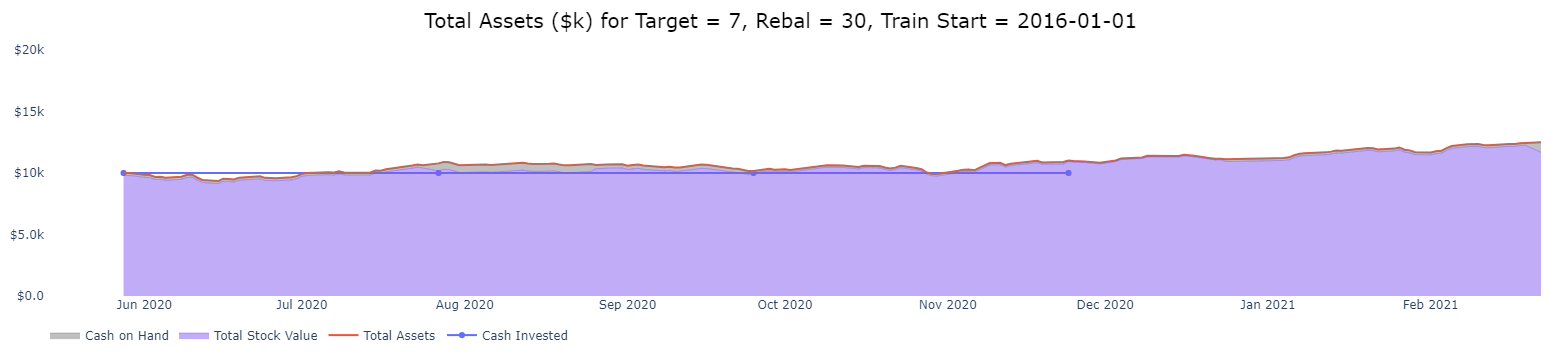

In [343]:
# Asset view for Target = 7 Days and Rebal_Interval = 30 Days and Train Start = 2016-01-01
create_asset_view(run_df2.iloc[1]['hist_open_positions'],run_df2.iloc[1]['remaining_cash'],\
                 run_df2.iloc[1]['target'],run_df2.iloc[1]['rebal_interval'],run_df2.iloc[1]['train_start_dt'])

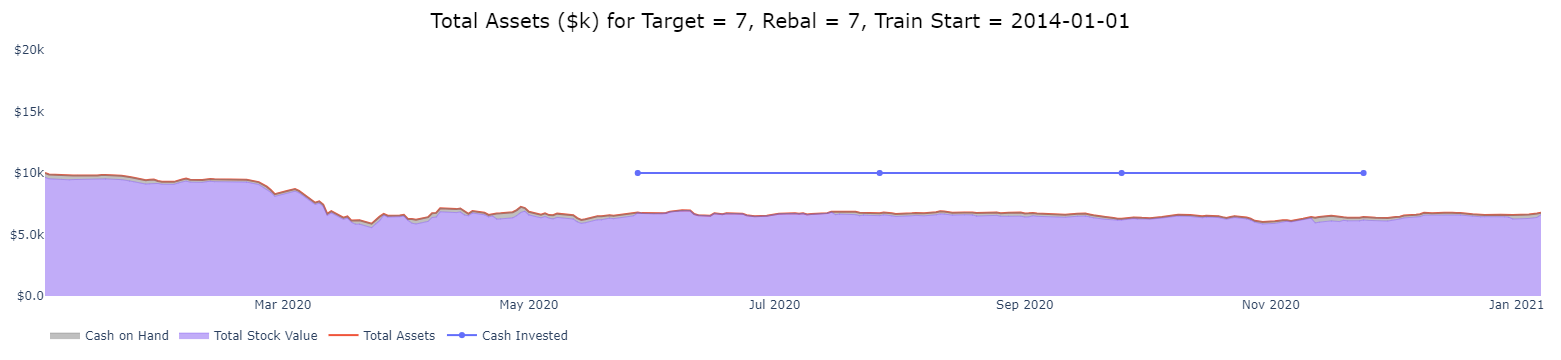

In [344]:
# Asset view for Target = 7 Days and Rebal_Interval = 7 Days and Train Start = 2014-01-01
create_asset_view(run_df2.iloc[2]['hist_open_positions'],run_df2.iloc[2]['remaining_cash'],\
                 run_df2.iloc[2]['target'],run_df2.iloc[2]['rebal_interval'],run_df2.iloc[2]['train_start_dt'])

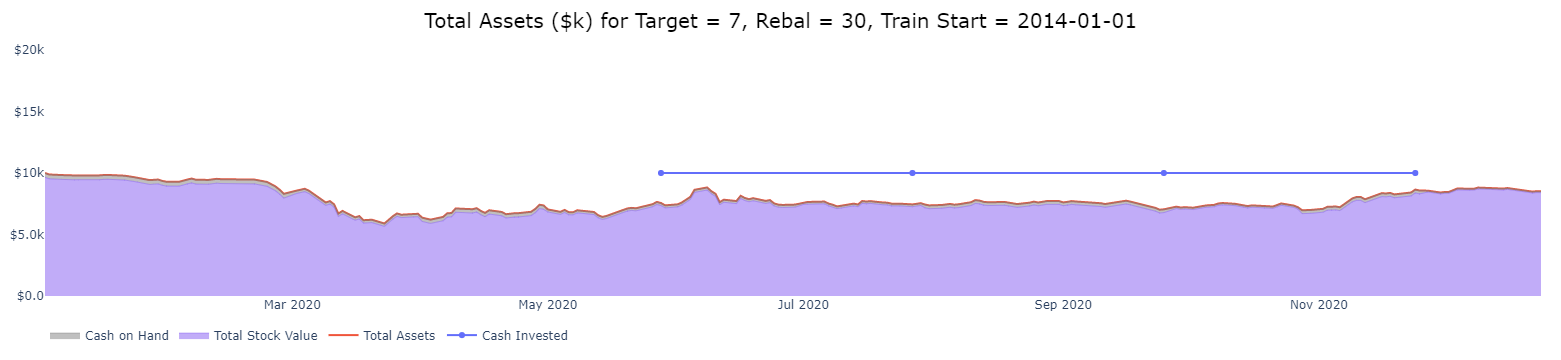

In [345]:
# Asset view for Target = 7 Days and Rebal_Interval = 30 Days and Train Start = 2014-01-01
create_asset_view(run_df2.iloc[3]['hist_open_positions'],run_df2.iloc[3]['remaining_cash'],\
                 run_df2.iloc[3]['target'],run_df2.iloc[3]['rebal_interval'],run_df2.iloc[3]['train_start_dt'])

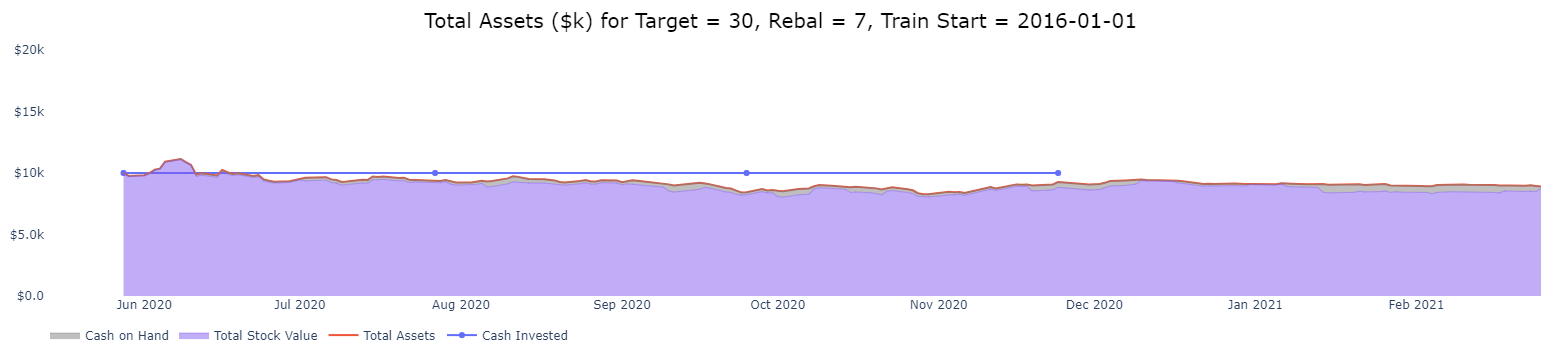

In [346]:
# Asset view for Target = 30 Days and Rebal_Interval = 7 Days and Train Start = 2016-01-01
create_asset_view(run_df2.iloc[4]['hist_open_positions'],run_df2.iloc[4]['remaining_cash'],\
                 run_df2.iloc[4]['target'],run_df2.iloc[4]['rebal_interval'],run_df2.iloc[4]['train_start_dt'])

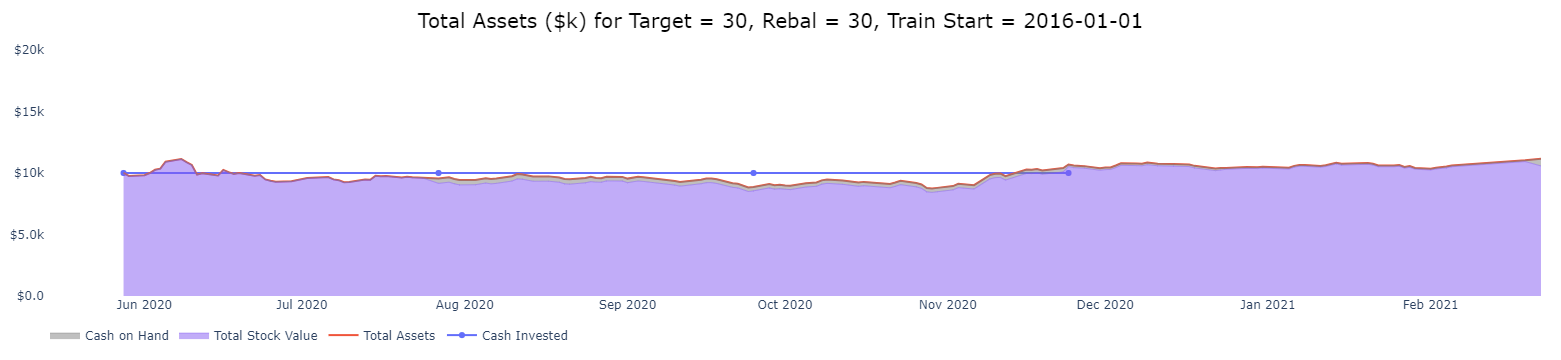

In [347]:
# Asset view for Target = 30 Days and Rebal_Interval = 30 Days and Train Start = 2016-01-01
create_asset_view(run_df2.iloc[5]['hist_open_positions'],run_df2.iloc[5]['remaining_cash'],\
                 run_df2.iloc[5]['target'],run_df2.iloc[5]['rebal_interval'],run_df2.iloc[5]['train_start_dt'])

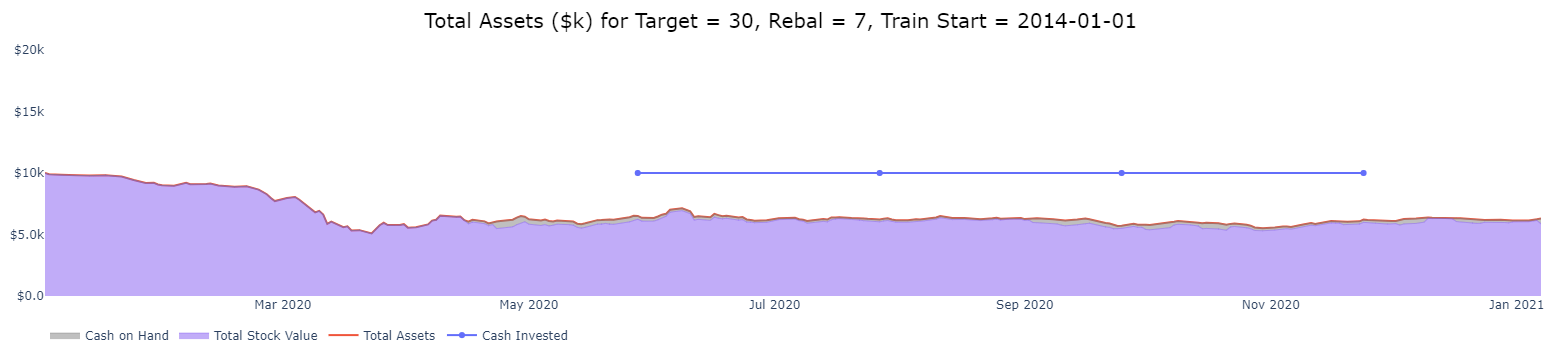

In [348]:
# Asset view for Target = 30 Days and Rebal_Interval = 7 Days and Train Start = 2014-01-01
create_asset_view(run_df2.iloc[6]['hist_open_positions'],run_df2.iloc[6]['remaining_cash'],\
                 run_df2.iloc[6]['target'],run_df2.iloc[6]['rebal_interval'],run_df2.iloc[6]['train_start_dt'])

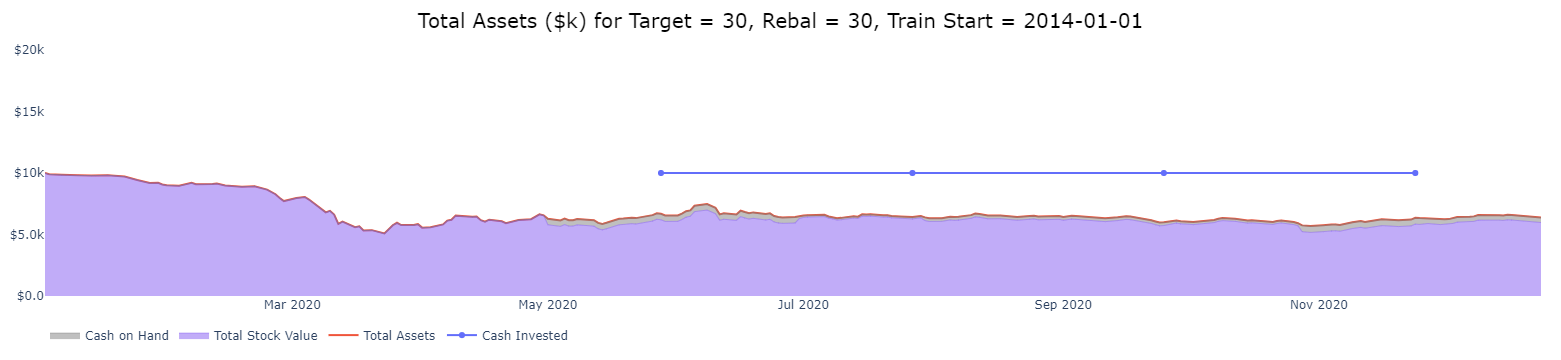

In [349]:
# Asset view for Target = 30 Days and Rebal_Interval = 30 Days and Train Start = 2014-01-01
create_asset_view(run_df2.iloc[7]['hist_open_positions'],run_df2.iloc[7]['remaining_cash'],\
                 run_df2.iloc[7]['target'],run_df2.iloc[7]['rebal_interval'],run_df2.iloc[7]['train_start_dt'])

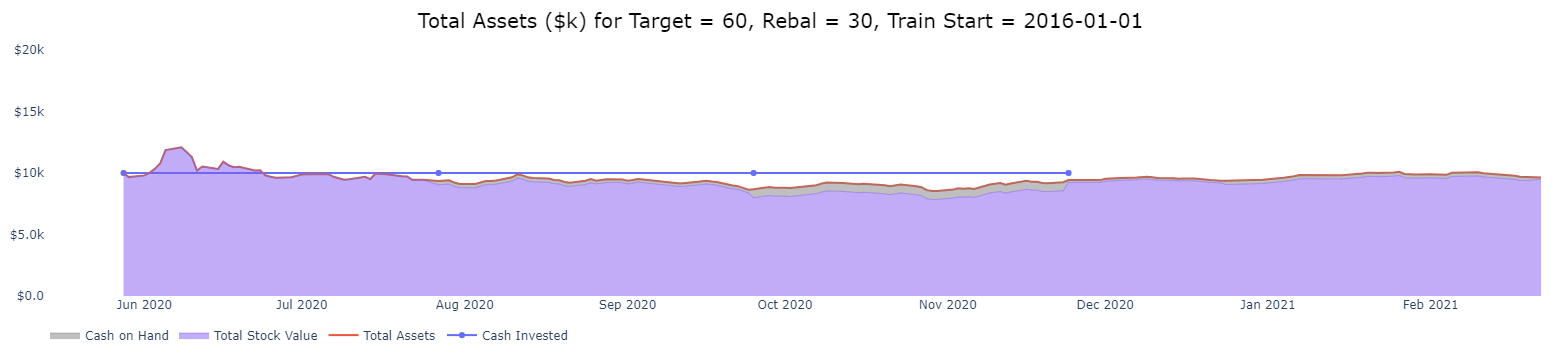

In [350]:
# Asset view for Target = 7 Days and Rebal_Interval = 7 Days and Train Start = 2016-01-01
create_asset_view(run_df2.iloc[8]['hist_open_positions'],run_df2.iloc[8]['remaining_cash'],\
                 run_df2.iloc[8]['target'],run_df2.iloc[8]['rebal_interval'],run_df2.iloc[8]['train_start_dt'])

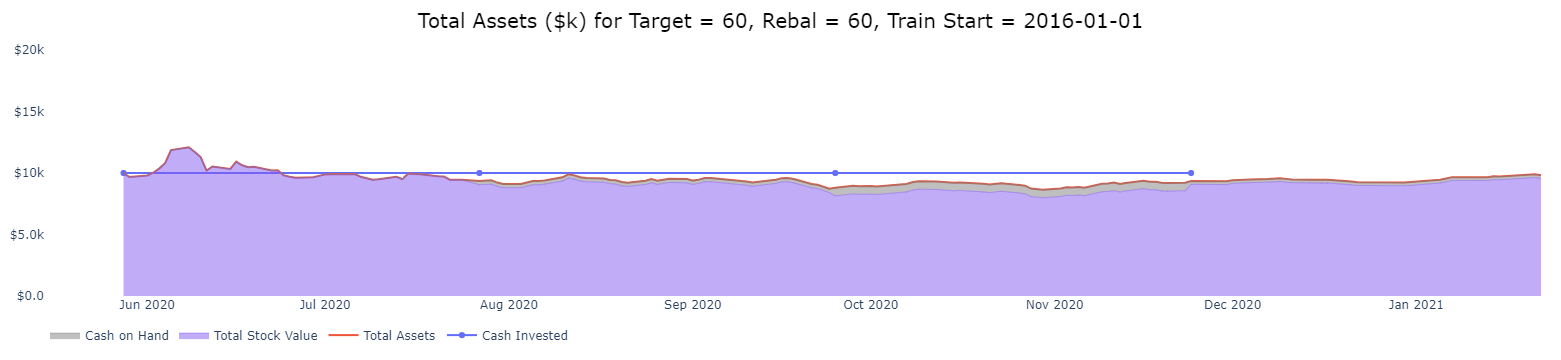

In [351]:
# Asset view for Target = 7 Days and Rebal_Interval = 7 Days and Train Start = 2016-01-01
create_asset_view(run_df2.iloc[9]['hist_open_positions'],run_df2.iloc[9]['remaining_cash'],\
                 run_df2.iloc[9]['target'],run_df2.iloc[9]['rebal_interval'],run_df2.iloc[9]['train_start_dt'])

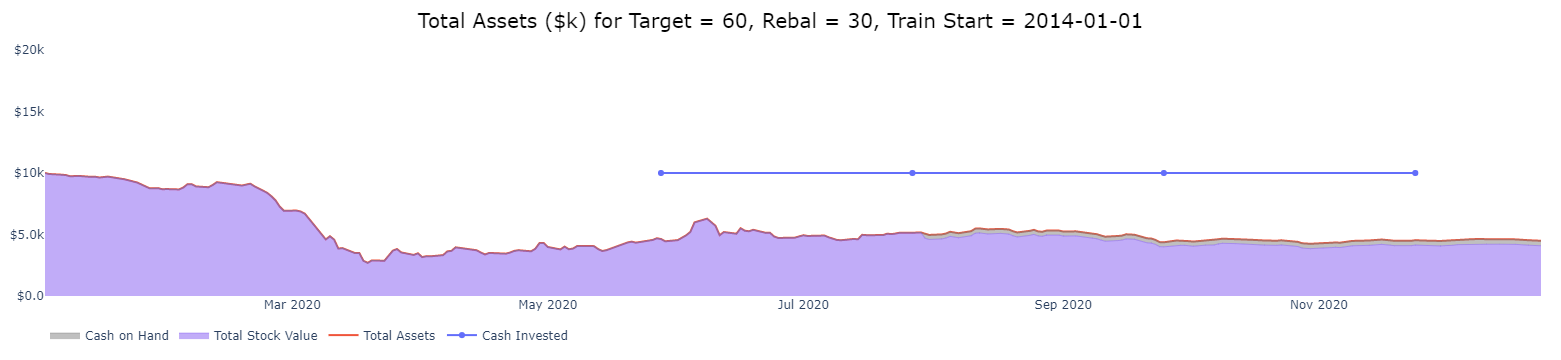

In [352]:
# Asset view for Target = 7 Days and Rebal_Interval = 7 Days and Train Start = 2016-01-01
create_asset_view(run_df2.iloc[10]['hist_open_positions'],run_df2.iloc[10]['remaining_cash'],\
                 run_df2.iloc[10]['target'],run_df2.iloc[10]['rebal_interval'],run_df2.iloc[10]['train_start_dt'])

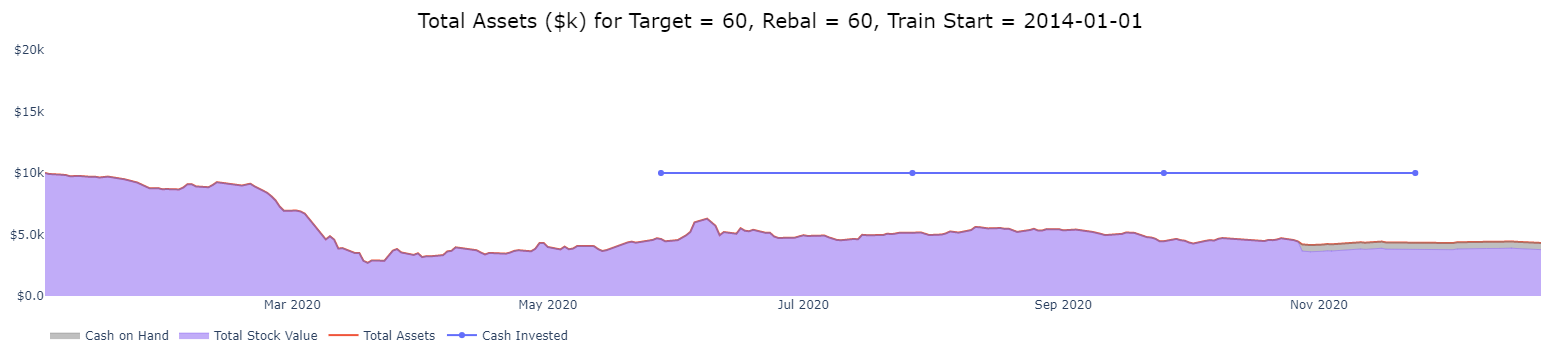

In [353]:
# Asset view for Target = 7 Days and Rebal_Interval = 7 Days and Train Start = 2014-01-01
create_asset_view(run_df2.iloc[11]['hist_open_positions'],run_df2.iloc[11]['remaining_cash'],\
                 run_df2.iloc[11]['target'],run_df2.iloc[11]['rebal_interval'],run_df2.iloc[11]['train_start_dt'])

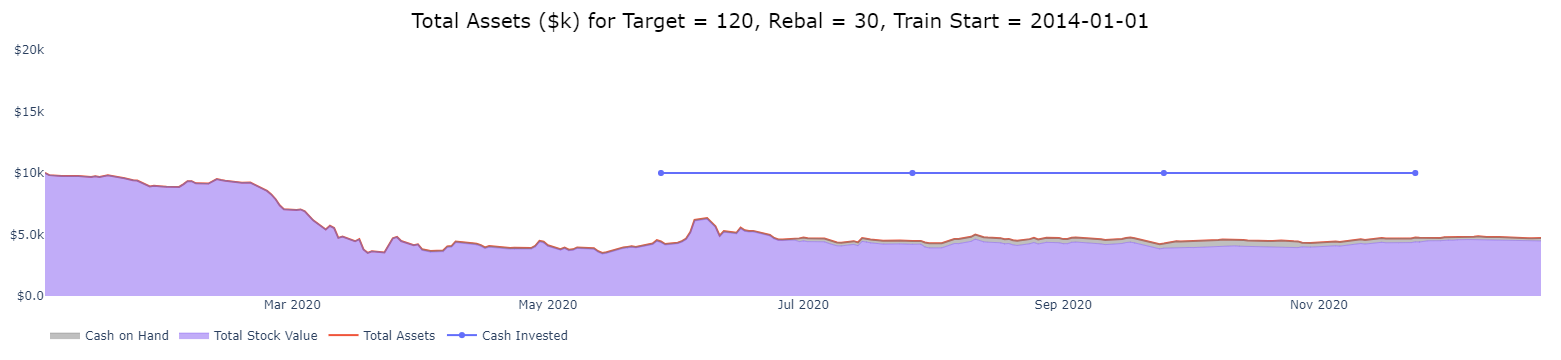

In [354]:
create_asset_view(run_df2.iloc[12]['hist_open_positions'],run_df2.iloc[12]['remaining_cash'],\
                 run_df2.iloc[12]['target'],run_df2.iloc[12]['rebal_interval'],run_df2.iloc[12]['train_start_dt'])

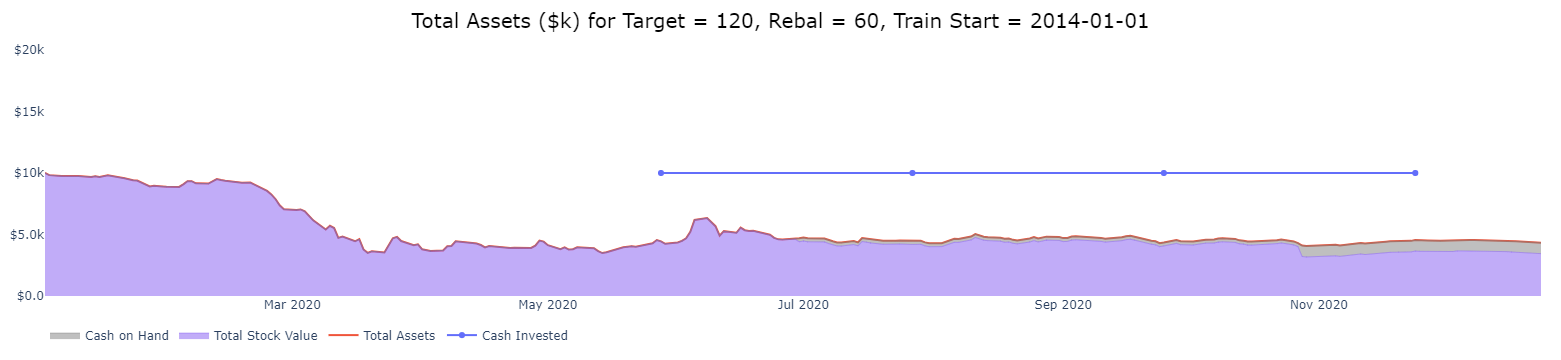

In [355]:
create_asset_view(run_df2.iloc[13]['hist_open_positions'],run_df2.iloc[13]['remaining_cash'],\
                 run_df2.iloc[13]['target'],run_df2.iloc[13]['rebal_interval'],run_df2.iloc[13]['train_start_dt'])

#### Action Items
1. Other views: Portfolio Makeup by sector
2. Add fundamental features, P/E Ratio, etc
3. Look at trending over time of earnings and compare to 2014-2016 timeframe (maybe earnings were not consistent?)
4. Rebuild best model potentially with different reggressor or PCA (remove covariance) and de-dupe covariant features
5. Create a classification model based on buy/sell thresholds? (essentially moving the buy sell strategy into target variable)

## Testing out new portfolio class created by Jeff

In [104]:
target = 60
rebal_interval = 30
train_start_dt = '2019-01-01'

In [38]:
# Putting everything above together
# This will assess prices and predictions every 7 days and change positions accordingly
import port_2 as port2

# Setting training dates. Will test on all data after
train_start_dt = '2019-01-01'

# Filtering to new_df just with dates we care about
new_df = feature_df[feature_df.index >=train_start_dt]

# Creating train_df and test_df
split_perc = .8
# Getting index values needed to split df
train_int = int(len(new_df.index.unique())*split_perc)

# Splitting new_df into train_df and test_df
train_df = new_df[new_df.index.isin(new_df.index.unique()[:train_int])]
test_df = new_df[new_df.index.isin(new_df.index.unique()[train_int:])]

train_end_dt = pd.to_datetime(new_df[new_df.index.isin(new_df.index.unique()[:train_int])]\
                              .index.max()).date().strftime('%Y-%m-%d')

# Initializing portfolio
# start_dt = test_df.index.min().strftime('%Y-%m-%d')
test = port2.portfolio(start_date='2019-01-01', value=100000, end_date='2021-07-02')

# curr_dt = test_df.index[0]

ticker_preds = pd.DataFrame(columns=['ticker','pred_date','pred_price','curr_dt','curr_price','earn_ratio'])

iteration = 0

# Setting configuration variables
target = 7
rebal_interval = 30

# Changing train end date for every iteration
next_train_end_dt = (pd.to_datetime(train_end_dt)+timedelta(7)).strftime('%Y-%m-%d')

ticker = 'PFE'

In [39]:
train_end_dt

'2020-12-30'

In [40]:
next_train_end_dt

'2021-01-06'

In [41]:
pred_date, pred_price, model = fit_model(ticker,train_start_dt,train_end_dt,target=target)

In [42]:
curr_price = test.get_price(date=train_end_dt,ticker=ticker)
earn_ratio = pred_price / curr_price - 1

ticker_preds = ticker_preds.append({'ticker':ticker,'pred_date':pred_date,'pred_price':pred_price,\
                                    'curr_dt':train_end_dt,'curr_price':curr_price,'earn_ratio':earn_ratio},ignore_index=True)

In [43]:
ticker_preds

ticker   pred_date  pred_price     curr_dt  curr_price  earn_ratio
0    PFE  2021-01-11   37.762017  2020-12-30   36.173666    0.043909

In [44]:
test.open_positions_df[test.open_positions_df['Ticker']=='PFE']['Quantity'].sum()

0

In [45]:
test.open_positions_df

Empty DataFrame
Columns: [Date, Ticker, Quantity, Basis, Purchase Price, Current Value, Last, % Gain]
Index: []

In [46]:
sell_dict = create_sell_dict(ticker_preds[ticker_preds['pred_date']==pred_date],test.open_positions_df,\
                                                         sell_threshold = -0.05)

In [47]:
sell_dict

{}

In [90]:
# Use to reload a module
importlib.reload(sys.modules['portfolio'])

<module 'portfolio' from '/Users/tylerdrumheller/Documents/Grad School/SIADS697/portfolio.py'>

In [48]:
# Does not work if no trades have been made yet
# test.execute_trades(sell_dict,train_start_dt,'Sell')

In [49]:
buy_dict = create_buy_dict(ticker_preds[ticker_preds['pred_date']==pred_date],test.current_cash,\
                                                                   buy_threshold=0.04)
buy_dict

{'PFE': 2764}

In [50]:
test.open_positions_df

Empty DataFrame
Columns: [Date, Ticker, Quantity, Basis, Purchase Price, Current Value, Last, % Gain]
Index: []

In [51]:
test.execute_trades(buy_dict,curr_dt.strftime('%Y-%m-%d'),'BUY')

Trades Executed


In [52]:
test.open_positions_df

Date Ticker  Quantity         Basis  Purchase Price  Current Value  \
0  2020-12-31    PFE      2764  99286.815155       35.921424   99286.815155   

        Last  % Gain  
0  35.921424     0.0

In [55]:
test_df.index[0]

Timestamp('2020-12-31 00:00:00')

In [56]:
# Setting train end date to last prediction date
train_end_dt = next_train_end_dt

# Changing train end date for every iteration
next_train_end_dt = (pd.to_datetime(train_end_dt)+timedelta(7)).strftime('%Y-%m-%d')

pred_date, pred_price, model = fit_model(ticker,train_start_dt,train_end_dt,target=target)

# Current price doesn't match actual price, because the function averages multiple prices
curr_price = test.get_price(date=train_end_dt,ticker=ticker)
earn_ratio = pred_price / curr_price - 1

ticker_preds = ticker_preds.append({'ticker':ticker,'pred_date':pred_date,'pred_price':pred_price,\
                                    'curr_dt':train_end_dt,'curr_price':curr_price,'earn_ratio':earn_ratio},ignore_index=True)


In [58]:
train_end_dt

'2021-01-06'

In [59]:
test.open_positions_df[test.open_positions_df['Ticker']=='PFE']['Quantity'].sum()

2764

In [60]:
sell_dict = create_sell_dict(ticker_preds[ticker_preds['pred_date']==pred_date],test.open_positions_df,\
                                                         sell_threshold = -0.05)
sell_dict

{}

In [62]:
test.execute_trades(sell_dict,curr_dt.strftime('%Y-%m-%d'),'Sell')

In [63]:
buy_dict = create_buy_dict(ticker_preds[ticker_preds['pred_date']==pred_date],test.current_cash,\
                                                                   buy_threshold=0.04)
buy_dict

{}

In [64]:
test.execute_trades(buy_dict,curr_dt.strftime('%Y-%m-%d'),'BUY')

Trades Executed


In [65]:
test.open_positions_df

Date Ticker  Quantity         Basis  Purchase Price  Current Value  \
0  2020-12-31    PFE    2764.0  99286.815155       35.921424   99286.815155   

        Last  % Gain  
0  35.921424     0.0

In [95]:
# Changing train end date for every iteration
next_train_end_dt = (pd.to_datetime(train_end_dt)+timedelta(7)).strftime('%Y-%m-%d')

# Re-fit every ticker model and predict price in the future
for ticker in tickers:

    pred_date, pred_price, model = fit_model(ticker,train_start_dt,next_train_end_dt,target=target)

    # Current price doesn't match actual price, because the function averages multiple prices
    curr_price = port2.get_price(date=pred_date,ticker=ticker)
    earn_ratio = pred_price / curr_price - 1

    ticker_preds = ticker_preds.append({'ticker':ticker,'pred_date':pred_date,'pred_price':pred_price,\
                                    'curr_price':curr_price,'earn_ratio':earn_ratio},ignore_index=True)

In [107]:
# Putting everything above together
# This will assess prices and predictions every 7 days and change positions accordingly

# Setting training dates. Will test on all data after
train_start_dt = '2019-01-01'

# Filtering to new_df just with dates we care about
new_df = feature_df[feature_df.index >=train_start_dt]

# Creating train_df and test_df
split_perc = .8
# Getting index values needed to split df
train_int = int(len(new_df.index.unique())*split_perc)

# Splitting new_df into train_df and test_df
train_df = new_df[new_df.index.isin(new_df.index.unique()[:train_int])]
test_df = new_df[new_df.index.isin(new_df.index.unique()[train_int:])]

train_end_dt = pd.to_datetime(new_df[new_df.index.isin(new_df.index.unique()[:train_int])]\
                              .index.max()).date().strftime('%Y-%m-%d')

# Initializing portfolio
# start_dt = test_df.index.min().strftime('%Y-%m-%d')
port2 = port2.portfolio(start_date='2019-10-01', value=100000, end_date='2021-07-02')

ticker_preds = pd.DataFrame(columns=['ticker','pred_date','pred_price','curr_price','earn_ratio'])

iteration = 0

# Setting configuration variables
target = 7
rebal_interval = 30

for i in range(0,len(test_df.index.unique()),rebal_interval):

    # Changing train end date for every iteration
    next_train_end_dt = (pd.to_datetime(train_end_dt)+timedelta(i)).strftime('%Y-%m-%d')

    # Re-fit every ticker model and predict price in the future
    for ticker in tickers:

        pred_date, pred_price, model = fit_model(ticker,train_start_dt,next_train_end_dt,target=target)

        # Current price doesn't match actual price, because the function averages multiple prices
        curr_price = port2.get_price(date=pred_date,ticker=ticker)
        earn_ratio = pred_price / curr_price - 1

        ticker_preds = ticker_preds.append({'ticker':ticker,'pred_date':pred_date,'pred_price':pred_price,\
                                        'curr_price':curr_price,'earn_ratio':earn_ratio},ignore_index=True)

    # Creating dictinary of stocks and positions to sell
    try:
        sell_dict = create_sell_dict(ticker_preds[ticker_preds['pred_date']==pred_date],test.open_positions_df,\
                                                         sell_threshold = -0.05)
        print(f'Current Selected Sells: {sell_dict} for {next_train_end_dt}')

        # Selling positions of stocks predicted to decline on day of training (EOD)
        port.sell(sell_dict,next_train_end_dt)

    # If no sells exist, then pass
    except:
        pass

    # Creating dictinary of stocks and positions to buy
    try:
        buy_dict = create_buy_dict(ticker_preds[ticker_preds['pred_date']==pred_date],port.current_cash,\
                                                                                   buy_threshold=0.05)
        print(f'Current Selected Buys: {buy_dict} for {next_train_end_dt}')

        # Buying positions of stocks predicted to increase on day of training (EOD)
        port.buy(buy_dict,next_train_end_dt)

    # If no buying exists, then pass
    except:
        pass

    iteration+=1
    hist_open_positions[next_train_end_dt] = port.open_positions_dict.copy()
#     print(port.open_positions_dict)
#     print(next_train_end_dt)

    print(f'Current Progress: {iteration} out of {int(len(test_df.index.unique())/rebal_interval)+1}')

    # Adding a break point for testing
    if iteration >= 5:
        break

run_df = run_df.append(pd.DataFrame.from_dict({'target':target,'rebal_interval':rebal_interval,'ticker_preds':ticker_preds,\
                             'hist_open_positions':hist_open_positions,'model':model,'train_start_dt':train_start_dt},orient='index').transpose())

Current Selected Sells: {} for 2020-05-28
Current Selected Buys: {'FE': 34, 'GE': 126, 'DAL': 28, 'UAL': 20, 'WFC': 28, 'KIM': 59, 'HST': 53, 'KMI': 37, 'F': 64, 'INTC': 5, 'AAL': 22, 'SBUX': 3, 'CSCO': 6, 'SO': 5, 'MO': 6, 'T': 8, 'DOW': 5, 'GILD': 3, 'NRG': 6, 'JPM': 2, 'XOM': 4, 'SLB': 9, 'PM': 2, 'HAL': 10, 'MPC': 4, 'BAC': 6, 'CBRE': 2, 'KO': 1} for 2020-05-28
Only buying 3 of BAC due to insufficient funds
Only buying 0 of CBRE due to insufficient funds
Only buying 0 of KO due to insufficient funds
Current Progress: 1 out of 10
Current Selected Sells: {'HAL': 10} for 2020-06-27
datetime.datetime(2020, 6, 27, 0, 0) from sell step
Current Selected Buys: {} for 2020-06-27
Current Progress: 2 out of 10
Current Selected Sells: {'AAL': 22, 'F': 64} for 2020-07-27
Current Selected Buys: {'KMI': 5, 'MPC': 2, 'GE': 7, 'XOM': 1, 'MO': 1, 'UAL': 1, 'KIM': 3, 'DAL': 1, 'T': 1, 'BAC': 1, 'SLB': 1, 'HST': 1} for 2020-07-27
Current Progress: 3 out of 10
Current Selected Sells: {'GE': 133, 'DAL':

KeyboardInterrupt: 